# Домашняя работа 3: Разработка модели детектирования объектов

##  Кудрявцева Юлия


На семинаре мы обсудили, разработали и попробовали `SSD` модель на базе `VGG16`, поэтому для успешного выполнения домашнего задания рекомендуется обратиться к семинару.

Задачи домашнего задания:
 - Загрузить набор данных и визуализировать объекты. (2 балла)
 - Разработать функцию для расчета метрики mAP задачи детектирования объектов. Продемонстрировать работу. (4 балла)
 - Натренировать `SSD` модель на базе VGG16. Продемонстрировать повышение метрики mAP (4 балла)
 - Разработать `SSD` модель согласно предлагаемой архитектуры на базе `ResNet18`. Продемонстрировать повышение метрики mAP (10 баллов)
 - (БОНУС) Добавить разнообразные аугментации изображений. Можно позаимствовать из других репозитариев с указанием источника. Повторить эксперименты (5 баллов)

## Описание предлагаемых исходных кодов
- voc_dataset.py     - загружает предлагаемый набор данных, здесь также возможно выполнять аугментации над данными.
- voc_dataloader.py  - формирует порцию данных.
- prior_boxes.py     - содержит все необходимые функции для работы с `prior` боксами.
    - prior_boxes - функция генерирует `prior` боксы в соотвествии с конфигурацией
    - match       - функция решает задачу сопоставления `ground truth` боксов из набора данных и `prior` боксов
    - decode      - функция вычисляет поправки между `ground truth` боксами и `prior` боксами, собственно их будет *предсказывать* наша модель
    - encode      - функция пересчитывает `prior` боксы и *предсказанные* поправки в результирующие детектирования

- model_vgg16.py   - реализация `SSD` на базе VGG16, которая рассматривалась на семинаре.
- multibox_loss.py - комплексная функция потерь, решается задача сопоставления *предсказанных* и `ground truth` боксов, применяется техника `hard-negative mining`, вычисляется общая функция потерь.

- train_model.py    - пример, который тренирует модель детектирования.
- evaluate_model.py - пример, который визуализирует результат работы модели детектирования.

## Архитектура модели на основе VGG16

Обязательно посмотрите реализацию и разберитесь в том, как устроенна модель, это будет полезно при разработке собственной модели детектирования.

![Image](output_vgg16.png)

## Архитектура модели на основе ResNet18

Можно исследовать реализацию ResNet в пакете PyTorch, это будет полезно при разработке собственного детектора.

https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

![Image](output_resnet18.png)

In [9]:
import numpy as np

import argparse
import torch
import time
import os
import matplotlib.pyplot as plt
import random
from matplotlib import patches,  lines
import colorsys


from voc_dataloader      import get_train_dataloader, get_test_dataloader

from model_vgg16     import SSD_VGG16
from multibox_loss   import MultiBoxLoss
from prior_boxes     import prior_boxes
from logger          import Logger

from tqdm import tqdm

## Создаем конфигурацию, которая описывает работы нашего детектора (пример для VGG16)

In [2]:
#VGG16
custom_config = {
 'num_classes'  : 3,
 'feature_maps' : [(90,160), (45,80), (23,40), (12,20), (10,18), (8,16)], #Размерность карт признаков, которые будут использоваться
 'min_sizes'    : [0.10, 0.20, 0.37, 0.54, 0.71, 1.00],
 'max_sizes'    : [0.20, 0.37, 0.54, 0.71, 1.00, 1.05],
 
 'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2], [2]], #Список содержаший информацию о соотношении сторон для prior боксов
 'num_priors'   : [6, 6, 6, 6, 4, 4], #Число prior боксов
 'variance'     : [0.1, 0.2],
 'clip'         :    True,

 'overlap_threshold': 0.5, #Параметр IoU
 'neg_pos_ratio'    :   3, #Параметр hard-negative mining

 'model_name' : 'vgg16'
}


## Загружаем требуемый набор данных

In [3]:
voc_root = 'dataset'
train_annotation_filename = os.path.join( voc_root, "ImageSets/Main/trainval.txt" )
test_annotation_filename  = os.path.join( voc_root, "ImageSets/Main/test.txt"     )
    
train_dataloader = get_train_dataloader(voc_root, train_annotation_filename, 16, 1) # set num_works to 1 due to windows
test_dataloader  = get_test_dataloader(voc_root, test_annotation_filename, 16, 1) # set num_works to 1 due to windows


In [158]:
for train_sample_s in train_dataloader:
        images, boxes, labels = train_sample_s
        print(train_sample_s)
        break

(tensor([[[[ 0.8789,  0.8789,  0.8618,  ..., -0.4739, -0.3541, -0.1828],
          [ 0.8789,  0.8789,  0.8789,  ..., -0.1828, -0.1143,  0.0398],
          [ 0.8961,  0.8961,  0.8789,  ...,  0.3309,  0.1939,  0.1597],
          ...,
          [ 0.5878,  0.4508,  0.4679,  ...,  0.7419,  0.7419,  0.7419],
          [ 0.5193,  0.4679,  0.4851,  ...,  0.7591,  0.7419,  0.7248],
          [ 0.5193,  0.5193,  0.4851,  ...,  0.7419,  0.7419,  0.7419]],

         [[ 0.9755,  0.9755,  0.9580,  ..., -0.4426, -0.3375, -0.1625],
          [ 0.9755,  0.9755,  0.9755,  ..., -0.1450, -0.0924,  0.0651],
          [ 0.9930,  0.9930,  0.9755,  ...,  0.3627,  0.2227,  0.1702],
          ...,
          [ 0.8179,  0.6779,  0.6954,  ...,  0.9755,  0.9755,  0.9755],
          [ 0.7479,  0.6954,  0.7129,  ...,  0.9930,  0.9755,  0.9580],
          [ 0.7479,  0.7479,  0.7129,  ...,  0.9755,  0.9755,  0.9755]],

         [[ 1.1237,  1.1237,  1.1062,  ..., -0.2358, -0.0964,  0.0779],
          [ 1.1237,  1.1237, 

In [160]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


In [174]:
def visualize(image, 
              bbox, 
              label,
              title='Image with boxes',
              scores=None, 
              ax=None,
              colors=None):
    
    h, w, _ = image.shape

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(title)

    for i, box in enumerate(bbox):
        
        x_min, y_min, x_max, y_max = box * np.array([w, h, w, h])
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor=colors[i], linewidth=2)
        ax.add_patch(rect)

        # add labels descriptions
        if scores is not None:
            ax.text(x_min, y_min, f"label: {label[i]}, confidence: {scores[i]}", 
                    fontsize=8, color=colors[i], verticalalignment='bottom')
        else:
            ax.text(x_min, y_min, f"label: {label[i]}", 
                    fontsize=8, color=colors[i], verticalalignment='bottom')




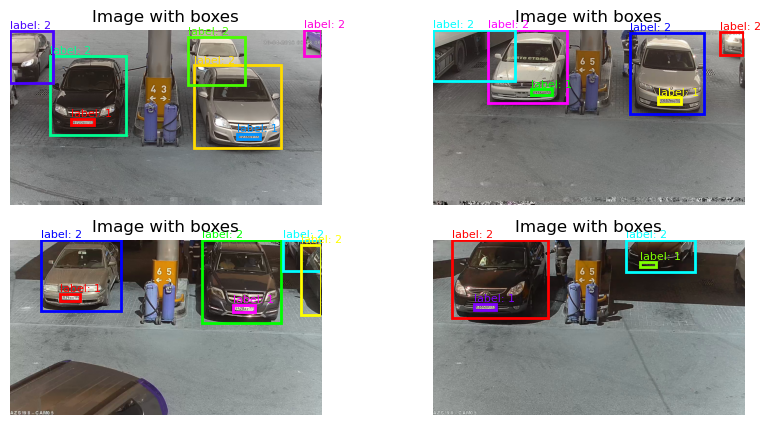

In [176]:
mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])


fig, axes = plt.subplots(2, 2, figsize=(10, 5))


for ind, ax in enumerate(axes.flatten()):

    N = boxes[ind].shape[0]
    colors = random_colors(N)
    bbox = boxes[ind].cpu().detach().numpy()
    label = labels[ind].cpu().detach().numpy()

    image = std*images[ind].permute(1, 2, 0).cpu().detach() + torch.tensor([0.485, 0.456, 0.406])
    image = image.numpy()
    visualize(image, 
              bbox, 
              label,
              scores=None, 
              ax=ax,
              colors=colors)
    
plt.show()

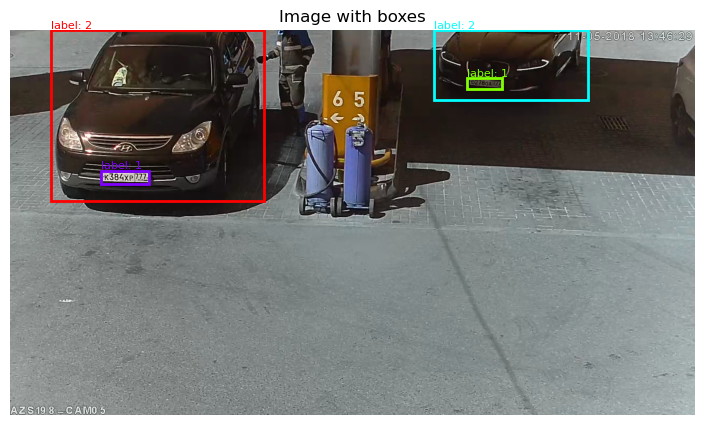

In [179]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

visualize(image, 
          bbox, 
          label,
          scores=None, 
          ax=axes,
          colors=colors
          )
plt.show()

## Разработать функцию вычисление mAP метрики задачи детектирования

In [456]:
def _mAP(true_labels, pred_labels, true_boxes, pred_boxes, scores, treshold=0.8):

    true_labels = true_labels.cpu().detach()
    pred_labels = pred_labels.cpu().detach()
    true_boxes = true_boxes.cpu().detach()
    pred_boxes = pred_boxes.cpu().detach()
    scores = scores.cpu().detach()

    # calculate IOU and treshold them
    IOUs = jaccard(true_boxes, pred_boxes) 
    treshold_mask = IOUs > treshold
    max_mask = IOUs ==  IOUs.max(dim=1)[0].reshape(-1, 1)
    positive_ind = (treshold_mask & max_mask).int().argmax(dim=1)
    
    # find boxes with 
    # isCorrect = torch.zeros_like(pred_labels)
    # isCorrect[positive_ind] = 1


    # sort values in ascending order
    indices = scores.argsort(dim = 0, descending=True)

    true_boxes = true_boxes[indices][positive_ind]
    pred_boxes = pred_boxes[indices][positive_ind]

    pred_labels = pred_labels[indices][positive_ind]
    true_labels = true_labels[indices][positive_ind]

    APperCLASS = []

    for current_label in true_labels.unique().numpy():

        # compute precision/recall for current class

        y_true = (true_labels == current_label).numpy().astype(int)
        y_pred = (pred_labels == current_label).numpy().astype(int)

        isCorrect = y_true == y_pred
        all_true = isCorrect.sum()

        precision = [isCorrect[:i].mean() for i in range(1, len(isCorrect)+1)]
        recall = [isCorrect[:i].sum()/ all_true for i in range(1, len(isCorrect)+1)]
        print(recall)


        # smoothing precision function
        precision_max = []
        curr_max = float('-inf')

        for val in  precision[::-1]:
            if val > curr_max:
                curr_max = val

            precision_max.append(curr_max)

        precision_max = precision_max[::-1]

        # calculate square under curve
        precsion_values, counts = np.unique(precision_max, return_counts=True)
        APperCLASS.append(np.sum(precsion_values * counts * recall[0]))

    return np.mean(APperCLASS)


In [457]:
def mAP(true_labels, pred_labels, true_boxes, pred_boxes, scores):
    return np.mean([
        _mAP(true_lab, pred_lab, true_box, pred_box, score) \
        for true_lab, pred_lab, true_box, pred_box, score in zip(true_labels, pred_labels, true_boxes, pred_boxes, scores)
        ])

In [458]:
mAP(labels, labels, boxes, boxes, scores)

[0.14285714285714285, 0.2857142857142857, 0.42857142857142855, 0.5714285714285714, 0.7142857142857143, 0.8571428571428571, 1.0]
[0.14285714285714285, 0.2857142857142857, 0.42857142857142855, 0.5714285714285714, 0.7142857142857143, 0.8571428571428571, 1.0]
[0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334, 1.0]
[0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334, 1.0]
[0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334, 1.0]
[0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334, 1.0]
[0.25, 0.5, 0.75, 1.0]
[0.25, 0.5, 0.75, 1.0]
[0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
[0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
[0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
[0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
[0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334, 1.0]
[0.16666666666666666, 0.3333333333

1.0

## Натренировать модель на основе VGG16

## Разработать модель на основе ResNet18

## Натренировать модель на основе ResNet18

## (БОНУС) Добавить разнообразные аугментации изображений в классе Dataset. Провести эксперименты и продемонстрировать метрику mAP.